In [1]:
import torch
import torchvision
import sklearn.metrics as metrics
import numpy as np
import sys
from torch.utils.data import Dataset, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import datetime

from d2l import torch as d2l  # pip install d2l

# COMP9444 Assignment 2

## Cat breed classification

## Neural Network

**student.py**

UNSW COMP9444 Neural Networks and Deep Learning

You may modify this file however you wish, including creating additional
variables, functions, classes, etc., so long as your code runs with the
hw2main.py file unmodified, and you are only using the approved packages.

You have been given some default values for the variables train_val_split,
batch_size as well as the transform function.
You are encouraged to modify these to improve the performance of your model.

**Answer to Question:**

Briefly describe how your program works, and explain any design and training
decisions you made along the way.

In [2]:
############################################################################
######     Specify transform(s) to be applied to the input images     ######
############################################################################

def transform(mode):
    """
    Called when loading the data. Visit this URL for more information:
    https://pytorch.org/vision/stable/transforms.html
    You may specify different transforms for training and testing
    """

    # channel size = 3

    if mode == 'train':
        return transforms.Compose(
            [   
                transforms.RandomResizedCrop(size=80, 
                         scale=(0.75, 1.0), ratio=(0.75, 1.3)), # original 80*80, avoid cropping important info
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation((-10,10)),
                transforms.ColorJitter(brightness=0.4, contrast=0.3, saturation=0.3, hue=0.2),
                transforms.RandomPosterize(bits=3, p=0.4),
                transforms.RandomEqualize(p=0.1),
                transforms.RandomGrayscale(p=0.1),
                transforms.RandomPerspective(distortion_scale=0.05, p=0.1, fill=0),
#                 T.RandomErasing(),
#                 T.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75)),
#                 T.RandomInvert(p=0.05),
                transforms.ToTensor()
            ]
        )
    elif mode == 'test':
        return transforms.Compose(
            [   
                transforms.ToTensor()  # keep original training data to ensure accuracy  
            ]
        )

In [3]:
class SimpleCNN(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 30, kernel_size=5, padding=2),
            nn.BatchNorm2d(30), 
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            
            nn.Conv2d(30, 120, kernel_size=3),
            nn.BatchNorm2d(120), 
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            
            nn.Conv2d(120, 360, kernel_size=3),
            nn.BatchNorm2d(360), 
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            
            nn.Conv2d(360, 540, kernel_size=3),
            nn.BatchNorm2d(540), 
            nn.ReLU(),
            nn.MaxPool2d((2, 2))
        )

        self.fc_layers = nn.Sequential(
            nn.Dropout(p=0.7),
            nn.Linear(540*3*3, 1600),
            nn.BatchNorm1d(1600), 
            nn.ReLU(),
            
            nn.Dropout(p=0.5),
            nn.Linear(1600, 1000),
            nn.BatchNorm1d(1000), 
            nn.ReLU(),
            
            nn.Dropout(p=0.3),
            nn.Linear(1000, 8)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
#         print(x.shape)
        x = torch.flatten(x, start_dim=1)
        x = self.fc_layers(x)
        return x
    
    
####################################################################################################################
# Re-implementation of AlexNet                                                                                     #
# https://github.com/pytorch/vision/blob/693829121bdc3e26714691f70241c6c01a089457/torchvision/models/alexnet.py    #
# Added Batch normalization, Leaky ReLU to prevent overfitting, reduced neurons in Hidden FC Layers for size res.  #
####################################################################################################################
class AlexNetModified(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Convolutional Layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(),
            nn.MaxPool2d((3, 3), stride=2),
            
            nn.Conv2d(192, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.MaxPool2d((2, 2), stride=2),
            
#             nn.Conv2d(256, 300, kernel_size=3, padding=1),
#             nn.BatchNorm2d(300),
#             nn.LeakyReLU(),
#             nn.MaxPool2d((2, 2), stride=2),
            
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.LeakyReLU(),
            nn.MaxPool2d((2, 2), stride=2),
            
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.LeakyReLU(),
            nn.MaxPool2d((2, 2), stride=2),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            # nn.MaxPool2d((2, 2), stride=2), # error if adds maxpoll here
            
            nn.Conv2d(256, 152, kernel_size=3, padding=1),
            nn.BatchNorm2d(152),
            nn.PReLU(),
            nn.MaxPool2d((2, 2), stride=2)
        )
        
        # shrink final conv layer width to 6
        self.avgpool = nn.AdaptiveAvgPool2d((6,6))
        
                
        # fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            
            nn.Dropout(p=0.6),
            nn.Linear(152*6*6, 1300),
            nn.BatchNorm1d(1300),
            nn.PReLU(),
            
            nn.Dropout(p=0.5),
            nn.Linear(1300, 1000),
            nn.BatchNorm1d(1000),
            nn.PReLU(),
            
            nn.Dropout(p=0.4),
            nn.Linear(1000, 8)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.avgpool(x)
        x = self.fc_layers(x)
        return x
    
        
net = AlexNetModified()

############################################################################
######      Specify the optimizer and loss function                   ######
############################################################################
learning_rate = 0.0004
# optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.5)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
# loss_func = F.nll_loss
loss_func = nn.CrossEntropyLoss()

############################################################################
######  Custom weight initialization and lr scheduling are optional   ######
############################################################################

# Normally, the default weight initialization and fixed learing rate
# should work fine. But, we have made it possible for you to define
# your own custom weight initialization and lr scheduler, if you wish.
def weights_init(m):
    return

scheduler = None


In [4]:
############################################################################
#######              Metaparameters and training options              ######
############################################################################
dataset = "./data"
train_val_split = 0.8
batch_size = 64
epochs = 200

In [5]:
##############################
### Tracking training time ###
##############################
start_time = time.time() ## Added
time_elapsed = 0  ## Added Line
##############################

###############################
### Tracking nn performance ###
###############################
minibatch_loss_list, train_accuracy_list, test_accuracy_list = [], [], [] ## Added
###############################

## HW 2 Main

In [6]:
# Use a GPU if available, as it should be faster.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


class DatasetFromSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)
    
    
# Test network on validation set, if it exists.
def test_network(net,testloader, test_accuracy_list, print_confusion=False):
    net.eval()
    total_images = 0
    total_correct = 0
    conf_matrix = np.zeros((8,8))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            conf_matrix = conf_matrix + metrics.confusion_matrix(
                labels.cpu(),predicted.cpu(),labels=[0,1,2,3,4,5,6,7])

    model_accuracy = total_correct / total_images * 100
    test_accuracy_list.append(model_accuracy)
    print(', {0} test {1:.2f}%'.format(total_images,model_accuracy))
    if print_confusion:
        np.set_printoptions(precision=2, suppress=True)
        print(conf_matrix)
    net.train()

Using device: cuda:0

test data distribution - {0: 806, 1: 798, 2: 804, 3: 812, 4: 786, 5: 799, 6: 789, 7: 806}
first item in last batch, label 1 - Calico


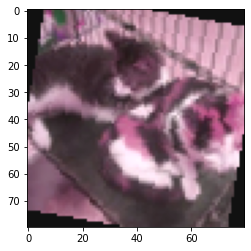

second item in last batch, label 1 - Calico


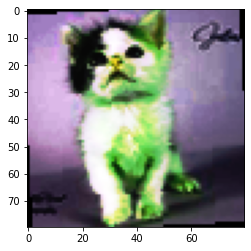

last item in last batch, label 5 - Tiger


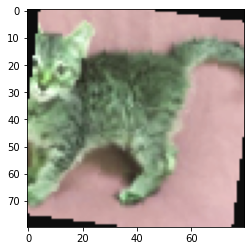

torch.Size([3, 80, 80])
batch size: 64
learning rate: 0.0004
train_val_split: 0.8
epochs: 200
Compose(
    RandomResizedCrop(size=(80, 80), scale=(0.75, 1.0), ratio=(0.75, 1.3), interpolation=bilinear)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=[0.6, 1.4], contrast=[0.7, 1.3], saturation=[0.7, 1.3], hue=[-0.2, 0.2])
    RandomPosterize(bits=3,p=0.4)
    RandomEqualize(p=0.1)
    RandomGrayscale(p=0.1)
    RandomPerspective(p=0.1)
    ToTensor()
)
AlexNetModified(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01

ep 36, loss: 44.40, 6400 train 84.50%, 1600 test 75.69%
ep 37, loss: 43.55, 6400 train 84.58%, 1600 test 72.38%
ep 38, loss: 41.92, 6400 train 85.31%, 1600 test 73.38%
ep 39, loss: 40.11, 6400 train 85.47%, 1600 test 71.00%
ep 40, loss: 38.24, 6400 train 86.62%, 1600 test 76.75%
[[157.   4.   0.  12.   0.   0.   5.  16.]
 [  0. 168.   3.   4.   2.   5.   4.  16.]
 [  5.  18. 133.  14.   6.   8.   4.   8.]
 [  2.   3.   0. 174.   1.   1.   0.   7.]
 [  0.  40.  12.  15. 132.   2.   0.  13.]
 [  1.  22.   2.   6.   0. 166.   2.   2.]
 [ 10.  34.   3.  16.   0.  10. 131.   7.]
 [  7.  14.   0.   4.   1.   1.   0. 167.]]
Time elapsed: 0:28:34.433296
   Model saved to checkModel.pth
ep 41, loss: 40.28, 6400 train 85.80%, 1600 test 75.50%
ep 42, loss: 36.14, 6400 train 87.33%, 1600 test 71.50%
ep 43, loss: 35.46, 6400 train 87.33%, 1600 test 74.00%
ep 44, loss: 34.95, 6400 train 87.95%, 1600 test 77.56%
ep 45, loss: 33.84, 6400 train 88.39%, 1600 test 75.06%
ep 46, loss: 34.66, 6400 train 87

ep 121, loss: 10.44, 6400 train 96.42%, 1600 test 79.69%
ep 122, loss: 9.93, 6400 train 96.69%, 1600 test 77.50%
ep 123, loss: 9.41, 6400 train 96.84%, 1600 test 78.75%
ep 124, loss: 10.03, 6400 train 96.69%, 1600 test 78.12%
ep 125, loss: 11.31, 6400 train 96.45%, 1600 test 77.69%
ep 126, loss: 10.50, 6400 train 96.50%, 1600 test 79.31%
ep 127, loss: 10.49, 6400 train 96.47%, 1600 test 78.00%
ep 128, loss: 11.70, 6400 train 95.69%, 1600 test 76.62%
ep 129, loss: 10.61, 6400 train 96.45%, 1600 test 75.56%
ep 130, loss: 12.11, 6400 train 95.89%, 1600 test 78.12%
[[155.   1.   0.   7.   0.   1.  18.  12.]
 [  1. 104.   0.   4.  22.  10.  29.  32.]
 [  2.   6. 125.   9.  21.   8.  16.   9.]
 [  6.   1.   1. 165.   2.   2.   3.   8.]
 [  4.   6.   4.   5. 181.   5.   2.   7.]
 [  0.   5.   1.   7.   5. 178.   5.   0.]
 [  9.   9.   1.   5.   1.   7. 172.   7.]
 [ 10.   6.   0.   2.   1.   1.   4. 170.]]
Time elapsed: 1:28:14.647726
   Model saved to checkModel.pth
ep 131, loss: 9.14, 6400 

In [7]:
# Cat breed dictionary 
cat_dict = {
    0: 'Bombay',
    1: 'Calico',
    2: 'Persian',
    3: 'Russian Blue',
    4: 'Siamese',
    5: 'Tiger',
    6: 'Tortoiseshell',
    7: 'Tuxedo'
}

# Main
print("Using device: {}"
      "\n".format(str(device)))
########################################################################
#######                      Loading Data                        #######
########################################################################
data = torchvision.datasets.ImageFolder(root=dataset)

if train_val_split == 1:
    # Train on the entire dataset
    data = torchvision.datasets.ImageFolder(root=dataset,
                        transform=transform('train'))
    trainloader = torch.utils.data.DataLoader(data,
                        batch_size=batch_size, shuffle=True);
else:
    # Split the dataset into trainset and testset
    data = torchvision.datasets.ImageFolder(root=dataset)
    data.len=len(data)
    train_len = int((train_val_split)*data.len)
    test_len = data.len - train_len
    train_subset, test_subset = random_split(data, [train_len, test_len])
    trainset = DatasetFromSubset(
        train_subset, transform=transform('train'))
    testset = DatasetFromSubset(
        test_subset, transform=transform('test'))

    trainloader = torch.utils.data.DataLoader(trainset, 
                        batch_size=batch_size, shuffle=False)
    testloader = torch.utils.data.DataLoader(testset, 
                        batch_size=batch_size, shuffle=False)

#########################
#**     REMOVABLE     **#
#########################
# Getting count of each cat breed, should be close to 0.8*1000 each--
total = 0
counter_dict = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0}
for data in trainloader:
    Xs, ys = data
    for y in ys:
        counter_dict[(int(y))] += 1
        total += 1
print(f'test data distribution - {counter_dict}')
# print(Xs) # last batch in our iteration size = 200 by default
# print(ys) # last batch (labels) in our iteration size = 200 by default
# https://stackoverflow.com/questions/53623472/how-do-i-display-a-single-image-in-pytorch/53633017
print(f'first item in last batch, label {ys[0]} - {cat_dict[ys.numpy()[0]]}')
plt.imshow(Xs[0].permute(1, 2, 0))
plt.show()
print(f'second item in last batch, label {ys[1]} - {cat_dict[ys.numpy()[1]]}')
plt.imshow(Xs[1].permute(1, 2, 0))
plt.show()
print(f'last item in last batch, label {ys[-1]} - {cat_dict[ys.numpy()[-1]]}')
plt.imshow(Xs[-1].permute(1, 2, 0))
plt.show()
print(Xs[0].shape)

## https://stackoverflow.com/questions/60101240/finding-mean-and-standard-deviation-across-image-channels-pytorch

# from torch.utils.data import TensorDataset, DataLoader

# nimages = 0
# mean = 0.0
# var = 0.0
# for i_batch, batch_target in enumerate(trainloader):
#     batch = batch_target[0]
#     # Rearrange batch to be the shape of [B, C, W * H]
#     batch = batch.view(batch.size(0), batch.size(1), -1)
#     # Update total number of images
#     nimages += batch.size(0)
#     # Compute mean and std here
#     mean += batch.mean(2).sum(0) 
#     var += batch.var(2).sum(0)

# mean /= nimages
# var /= nimages
# std = torch.sqrt(var)

# print('mean')
# print(mean)
# print('std')
# print(std)

#############################
#**     REMOVABLE END     **#
#############################

# Get model, loss criterion and optimizer from student
net = net.to(device)

#########################
#**    REMOVABLE_2    **#
#########################
print(f'batch size: {batch_size}')
print(f'learning rate: {learning_rate}')
print(f'train_val_split: {train_val_split}')
print(f'epochs: {epochs}')

print(transform('train'))

print(net)
from prettytable import PrettyTable
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
count_parameters(net)
#############################
#**    REMOVABLE_2 END    **#
#############################

criterion = loss_func
optimizer = optimizer
# get weight initialization and lr scheduler, if appropriate
weights_init = weights_init
scheduler = scheduler

# apply custom weight initialization, if it exists
net.apply(weights_init)

########################################################################
#######                        Training                          #######
########################################################################

#### d2l real time plot helper training function, install: pip install d2l
# d2l.train_ch6(net, trainloader, testloader, epochs, learning_rate, d2l.try_gpu())

print("Start training...")
for epoch in range(1,epochs+1):
    total_loss = 0
    total_images = 0
    total_correct = 0

    for batch in trainloader:           # Load batch
        images, labels = batch 
        images = images.to(device)
        labels = labels.to(device)

        preds = net(images)             # Process batch

        loss = criterion(preds, labels) # Calculate loss

        optimizer.zero_grad()
        loss.backward()                 # Calculate gradients
        optimizer.step()                # Update weights

        output = preds.argmax(dim=1)

        total_loss += loss.item()
        total_images += labels.size(0)
        total_correct += output.eq(labels).sum().item()
        minibatch_loss_list.append(loss.item())  

    # apply lr schedule, if it exists
    if scheduler is not None:
        scheduler.step()

    model_accuracy = total_correct / total_images * 100
    train_accuracy_list.append(model_accuracy)
    print('ep {0}, loss: {1:.2f}, {2} train {3:.2f}%'.format(
           epoch, total_loss, total_images, model_accuracy), end='')

    if train_val_split < 1:
        test_network(net,testloader, test_accuracy_list,
                     print_confusion=(epoch % 10 == 0))
    else:
        print()

    if epoch % 10 == 0:
        time_elapsed = time.time() - start_time  ## Added Line
        print(f'Time elapsed: {str(datetime.timedelta(seconds = time_elapsed))}') ## Added
        torch.save(net.state_dict(),'checkModel.pth')
        print("   Model saved to checkModel.pth")        

    sys.stdout.flush()

time_elapsed = time.time() - start_time
print(f'total time needed to train network: {str(datetime.timedelta(seconds = time_elapsed))}\ntotal time in seconds: {time_elapsed}')
torch.save(net.state_dict(),'savedModel.pth')
print("   Model saved to savedModel.pth")

### Analysis

batch size: 64
learning rate: 0.0004
train_val_split: 0.8
epochs: 200
training data - total instances = 6400
test data - total instances = 1600
training data distribution - {0: 806, 1: 798, 2: 804, 3: 812, 4: 786, 5: 799, 6: 789, 7: 806}
test data distribution - {0: 194, 1: 202, 2: 196, 3: 188, 4: 214, 5: 201, 6: 211, 7: 194}


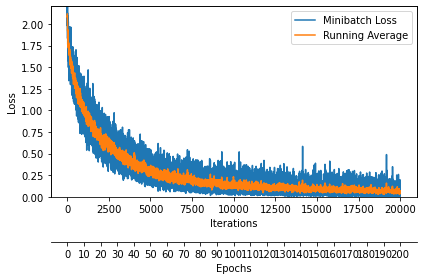

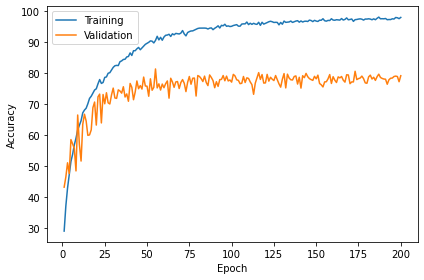

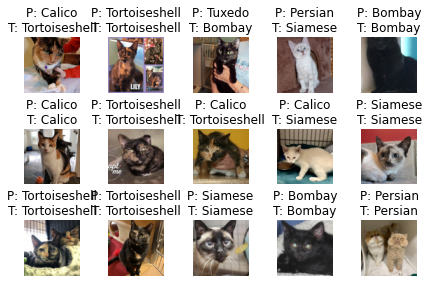

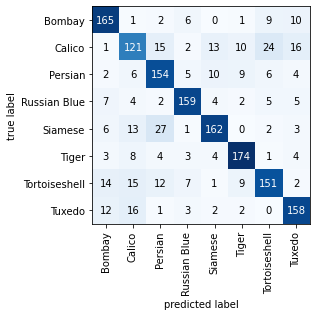

In [10]:
from helper import get_cat_count, count_parameters, \
    compute_confusion_matrix, show_examples, plot_training_loss, plot_accuracy, plot_confusion_matrix
###################################
#**        Data Information     **#
###################################
print(f'batch size: {batch_size}')
print(f'learning rate: {learning_rate}')
print(f'train_val_split: {train_val_split}')
print(f'epochs: {epochs}')


#############################
#**         END           **#
#############################


# Getting count of each cat breed, should be close to 8*0.8*1000 initially..
train_data_distribution = get_cat_count(trainloader, 'training data')
# Getting count of each cat breed, should be close to 8*0.2*1000 initially..
test_data_distribution = get_cat_count(testloader, 'test data')

print(f'training data distribution - {train_data_distribution}')
print(f'test data distribution - {test_data_distribution}')

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=epochs,
                   iter_per_epoch=len(trainloader),
                   results_dir=None,
                   averaging_iterations=10)
plt.show()


plot_accuracy(train_acc_list=train_accuracy_list,
              test_acc_list=test_accuracy_list,
              results_dir=None)
plt.show()

net.cpu()
show_examples(model=net, data_loader=testloader, class_dict=cat_dict)

conf_matrix = compute_confusion_matrix(model=net, data_loader=testloader, device=torch.device('cpu'))

plot_confusion_matrix(conf_matrix, class_names=cat_dict.values())
plt.show()